# Start Dask

In [1]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

/anaconda3/envs/overscripted/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


# Objective

The objective of this notebook is to answer: 
 - "The JSON values are always from the same location or related domains?" 

To answer this we will use the sample data set produced by the notebook "isJson_dataPrep.ipynb":
- 's0_domains_isJson_jsonKeys_md5_TLD_JSON_ONLY.parquet'


## Findings
To answer the question "The JSON values are always from the same location or related domains?"  
NO not aways, but usually. 83.09% of the JSONs are produced by a single script domain. 

---

About 71% of the JSONs are seen more than once across the data set, that means that they MAY have different origins.
- Most JSON are from a single script domain. 
- Almost 17% of the JSONs have multiple origins<sup>[1]</sup>, mostly they have 2 to 3 origins, very few have more than this. 
- They may be related for 40% of them have the same TLD<sup>[2]</sup>. 
- Some of the ones that have multiple script domains have the same location domain (41%) calling different scripts but producing the same JSON<sup>[3]</sup>. 
- They may have some similarities in usage, 99% of them have a single simbol across the different domains<sup>[4]</sup>

---
<small> For further investigation: 
    1. Are this jsons any different? Are they big/small jsons? I may be that they have the same top keys but are in reality very different? 
    2. Do the scripts domains that produces the same json have any relation between them? How can I relate domains?
    3. What does it mean to different scripts get the same JSON for a single Location? 
    4. Are they used for the same purpose? can we really say that based on the symbol? 

In [2]:
DIR = 'sample_0_prep/'

In [3]:
df = dd.read_parquet(DIR + 's0_domains_isJson_jsonKeys_md5_TLD_JSON_ONLY.parquet',
                         engine='pyarrow',
                         columns=['symbol', 'location_domain', 'script_domain', 'json_keys', 'keys_md5', 'script_tld', 'value_len'])
df.columns

Index(['symbol', 'location_domain', 'script_domain', 'json_keys', 'keys_md5',
       'script_tld', 'value_len'],
      dtype='object')

---

# The JSON values are always from the same location or related domains?
How many locations one JSON has?
All bigger json have the same locations?
what is "related domains"?


In [4]:
with ProgressBar():
    group_by_keys_md5 = df.compute().groupby(['keys_md5'])
    group_by_keys_md5_number_of_different_keys = len(group_by_keys_md5)
    print("The total number of different {} is {}".format('keys_md5', group_by_keys_md5_number_of_different_keys))

[########################################] | 100% Completed |  1.8s
The total number of different keys_md5 is 14374


In [5]:
agg = group_by_keys_md5.agg(['nunique'])

In [6]:

json_multiple_appearances = agg['symbol'][group_by_keys_md5['symbol'].count() > 1]
json_multiple_appearances_len = len(json_multiple_appearances)
agg_len = len(agg['symbol'])
print('There are a total of {0}({1:0.2f}%) JSONs that appear in multiple rows'.format(
    json_multiple_appearances_len, 
    json_multiple_appearances_len*100/agg_len))

There are a total of 10222(71.11%) JSONs that appear in multiple rows


In [7]:
def get_multiple(agg, column, title=''):
    agg_len = len(agg[column])
    x = agg[agg[column]['nunique'] > 1]
    x_len = len(x)
    print(title + '{0} ({1:0.2f}%) multiple {2},\n{3} ({4:0.2f}%) unique {2}'.format(
        x_len,
        x_len*100/agg_len,
        column, 
        agg_len - x_len,
        (agg_len - x_len) * 100 / agg_len
    ))
    return x

### JSONs origin: script domain

Plot that shows that most JSONs are originated from a single script domain

SCRIPT DOMAIN data: from the total of json
2430 (16.91%) multiple script_domain,
11944 (83.09%) unique script_domain


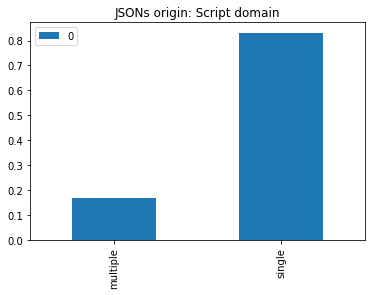

In [8]:
multiple_script_domain = get_multiple(agg, 'script_domain', 'SCRIPT DOMAIN data: from the total of json\n')
pd.DataFrame([[len(multiple_script_domain)/agg_len], 
              [(agg_len - len(multiple_script_domain))/agg_len]], 
            ['multiple', 'single']).plot(kind='bar', title='JSONs origin: Script domain')

In [9]:
multiple_script_domain.script_domain['nunique'].describe()

count    2430.000000
mean        2.483128
std         1.213823
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        34.000000
Name: nunique, dtype: float64

In [10]:
# Out of the multiple_script_domain
multiple_script_domain_symbol = get_multiple(multiple_script_domain, 'symbol')

7 (0.29%) multiple symbol,
2423 (99.71%) unique symbol


In [11]:
# Out of the multiple_script_domain
multiple_script_domain_location_tld = get_multiple(multiple_script_domain, 'script_tld')

1413 (58.15%) multiple script_tld,
1017 (41.85%) unique script_tld


In [12]:
# Out of the multiple_script_domain
multiple_script_domain_location_tld = get_multiple(multiple_script_domain, 'location_domain')

98 (4.03%) multiple location_domain,
2332 (95.97%) unique location_domain
